<a href="https://colab.research.google.com/github/Dimildizio/DS_course/blob/main/Neural_networks/Transfer_learning/TVshow_characters_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simpsons characters classification

## Install libs

In [1]:
!pip install kaggle wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.9/243.9 kB 14.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.6 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8791 sha256=d40915b89c0a313b7a43974626ff7f7a37aed78daf69222bcf5500526f029a5d
  Stored in directory: /root/.cache/pip/wheels/e7/f3/22/152153d6eb222ee7a56ff8617d80ee5207207a8c00a7aab794
Successfully built pathtools


## imports

In [2]:
import numpy as np
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import seaborn as sns
import torch
import torch.nn as nn
import wandb


from matplotlib.font_manager import FontProperties
from pathlib import Path
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.optim import Adam, AdamW, lr_scheduler
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms
from tqdm import tqdm, tqdm_notebook

### Create folder and download the dataset

If you want to follow this track, don't forget to put **your** kaggle API (download kaggle.json from kaggle.com) in the current dirrectory (I assume its 'content' for you)

In [3]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c journey-springfield
!unzip -q journey-springfield.zip

100% 520M/521M [00:06<00:00, 23.0MB/s]
100% 521M/521M [00:06<00:00, 86.7MB/s]


If you cannot perform the actions above or you don't have kaggle account (what are you doing here then?) - uncomment and use the code below. Of course you need to mound the drive and upload your version of dataset

In [5]:
#from google.colab import drive
#drive.mount('/content/gdrive/')
#!unzip -q /content/gdrive/MyDrive/journey-springfield.zip

### Sort data in order and get labels

In [4]:
path_train = Path('./train/')
path_test = Path('./testset/')

train_val_files = sorted(list(path_train.rglob('*.jpg')))
test_files = sorted(list(path_test.rglob('*.jpg')))

train_val_labels = [path.parent.name for path in train_val_files]

### Check characters distribution in train dataset

In [5]:
def plot_character_distribution(train_labels):
    plt.figure(figsize=(12,6))
    counts = pd.Series(train_labels).value_counts()
    sns.barplot(x=counts.sort_values(ascending=False), y=counts.keys())
    plt.tight_layout()
    plt.show()
    return counts

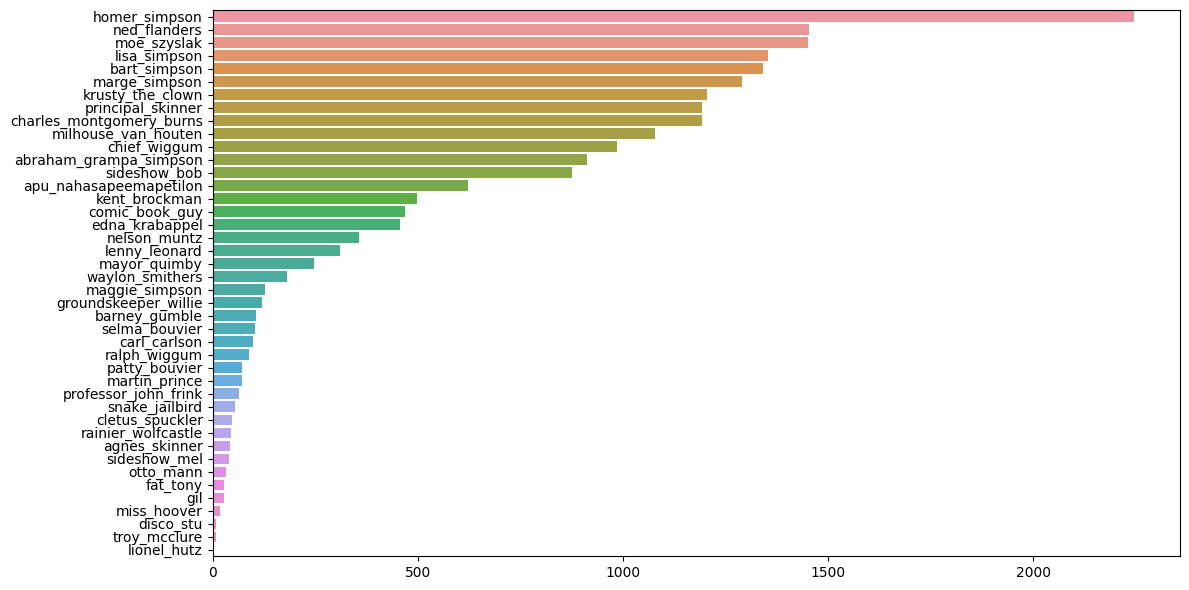

In [6]:
charnums = plot_character_distribution(train_val_labels)

### Split train labels into train and val data with stratification

In [40]:
train_files, val_files = train_test_split(train_val_files, test_size=0.25, stratify=train_val_labels)

train_labels = [path.parent.name for path in train_files]
val_labels = [path.parent.name for path in val_files]

## Load images as Datasets

In [8]:
class CFG:
  rescale_image = 224
  imagenet_means = [0.485, 0.456, 0.406]
  imagenet_stds = [0.229, 0.224, 0.225]
  batchsize = 64
  lr = 3e-4
  device = lambda: 'cuda' if torch.cuda.is_available() else 'cpu'

In [9]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow for tensors"""
    inp = np.array(CFG.imagenet_stds) * inp.numpy().transpose(
                                      (1, 2, 0)) + np.array(CFG.imagenet_means)
    inp = np.clip(inp, 0, 1)

    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [10]:
class CustomDataset(Dataset):
  def __init__(self, files, train=True):
    super().__init__()
    self.files = sorted(files)
    self.le = LabelEncoder()
    self.train_mode = train
    if train:
      self.labels = self.l_encode

  def __len__(self):
    return len(self.files)

  def __getitem__(self, idx):
    filename = self.files[idx]
    img = self._load_sample(filename)
    img = self._get_augs(img) if self.train_mode else self._get_transforms(img)
    return self._get_xy(img, idx)


  @staticmethod
  def _load_sample(name):
    img = Image.open(name)
    img.load()
    img = img.resize((CFG.rescale_image, CFG.rescale_image))
    return img

  @property
  def l_encode(self):
    labels = [path.parent.name for path in self.files]
    self.le.fit(labels)
    with open('le.pkl', 'wb') as f:
      pickle.dump(self.le, f)
    return labels


  def _get_xy(self, x, y_idx):
    if self.train_mode:
      label = self.labels[y_idx]
      label_id = self.le.transform([label])
      return x, label_id.item()
    else:
      return x


  @staticmethod
  def _get_augs(img):
    percentile = CFG.rescale_image//10
    transform = transforms.Compose([transforms.CenterCrop(size=CFG.rescale_image),

                                    transforms.RandomCrop(CFG.rescale_image - percentile),
                                    transforms.RandomResizedCrop(CFG.rescale_image),
                                    transforms.RandomRotation(degrees=(
                                                      -percentile, percentile)),
                                    transforms.RandomHorizontalFlip(p=0.9),
                                    transforms.Resize(size=(CFG.rescale_image,
                                                            CFG.rescale_image)),
                                    transforms.Lambda(lambda x: np.array(
                                                    x, dtype='float32') / 255),
                                    transforms.ToTensor(),
                                    transforms.Normalize(CFG.imagenet_means,
                                                         CFG.imagenet_stds)])
    return transform(img)



  @staticmethod
  def _get_transform(img):
    transform = transforms.Compose([transforms.Resize(size=(CFG.rescale_image,
                                                            CFG.rescale_image)),
                                    transforms.Lambda(lambda x: np.array(
                                                      x, dtype='float32') / 255),
                                    transforms.ToTensor(),
                                    transforms.Normalize(CFG.imagenet_means,
                                                         CFG.imagenet_stds)])
    return transform(img)



### Set two kinds of data - for train: train and val and for test: trainval and test

In [11]:
train_dataset = CustomDataset(train_files)
val_dataset = CustomDataset(val_files)

trainval_dataset = CustomDataset(train_val_files)
test_dataset = CustomDataset(test_files, False)

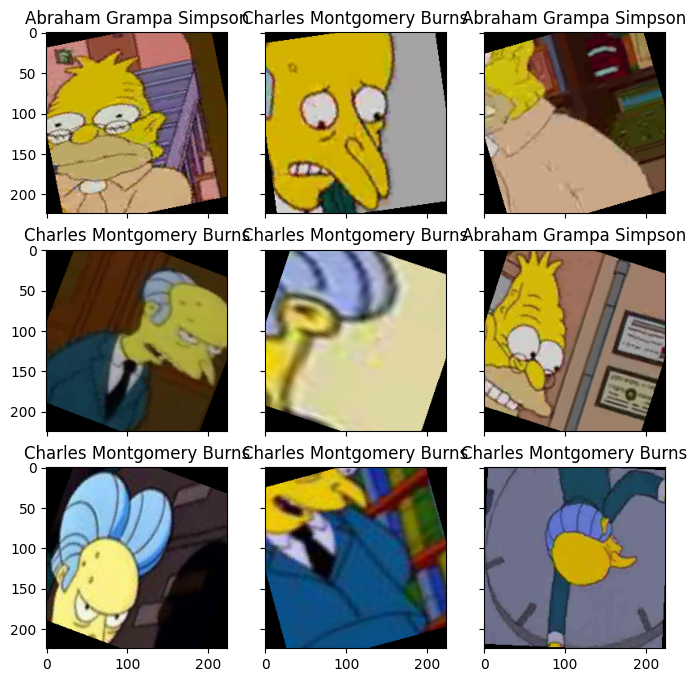

In [12]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.le.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

### Using random weighted sampler

kudos to [wervlad](https://www.kaggle.com/code/wervlad/baseline-2fc-augmentations) [vladislavzenin](https://www.kaggle.com/code/vladislavzenin/weightedrandomsampler) and [ndyarrrr](https://www.kaggle.com/code/ndyarrrr/1-0-score-with-baseline-model-3fc) for the WightedSampler

#### vladislavzenin and wervlad's approach

In [13]:
weights_count = {k: 1/v for k,v in charnums.items()}
weights_samples = [weights_count[label] for label in train_val_labels]
N_vw = charnums.max() * len(weights_count)

train_sampler_1 = WeightedRandomSampler(weights_samples, num_samples=int(N_vw), replacement=True)
train_loader_1 = DataLoader(trainval_dataset, batch_size=CFG.batchsize, sampler=train_sampler_1, num_workers=2)

#### ndyarrrr's approach

In [20]:
count_weights = {key: 1/value for key, value in charnums.items()}
sample_weights = len(train_val_files) * [0]

for i, (data, label) in enumerate(tqdm(trainval_dataset)):
    label_weight = count_weights[trainval_dataset.le.inverse_transform([label])[0]]
    sample_weights[i] = label_weight

100%|██████████| 20933/20933 [04:24<00:00, 79.15it/s]


In [24]:
N_n = charnums.max() * len(count_weights)
print(N_n)
train_sampler_2 = WeightedRandomSampler(sample_weights, num_samples=int(N_n), replacement=True)
train_dataloader_2 = DataLoader(trainval_dataset, batch_size=CFG.batchsize*2, sampler=train_sampler_2) #one worker twice tha batchsize

94332


#### compare dicts in two approaches

In [22]:
weights_count == count_weights

True

We are going to utilize all of this in the final part of learning when we train on train+val dataset but lets have a useful func instead of creating one instance in a cell

In [14]:
def weighted_dataloader_1(datasetfiles):
  labels = [path.parent.name for path in datasetfiles]
  counts = pd.Series(labels).value_counts()
  weights_count = {key: 1/val for key, val in counts.items()}
  weights_samples = [weights_count[label] for label in labels]
  N_vw = counts.max() * len(weights_count)
  sampler = WeightedRandomSampler(weights_samples, num_samples=int(N_vw), replacement=True)

  dataset = CustomDataset(datasetfiles)
  loader = DataLoader(dataset, batch_size=CFG.batchsize, sampler=sampler, num_workers=2)
  return loader

In [17]:
def weighted_dataloader_2(datasetfiles):
  labels = [path.parent.name for path in datasetfiles]
  counts = pd.Series(labels).value_counts()
  count_weights = {key: 1/value for key, value in counts.items()}
  sample_weights = len(datasetfiles) * [0]

  dataset = CustomDataset(datasetfiles)

  for i, (data, label) in enumerate(tqdm(dataset)):
      label_weight = count_weights[dataset.le.inverse_transform([label])[0]]
      sample_weights[i] = label_weight

  N_n = counts.max() * len(count_weights)
  sampler = WeightedRandomSampler(sample_weights, num_samples=int(N_n),
                                        replacement=True)

  loader = DataLoader(dataset, batch_size=CFG.batchsize,
                                sampler=sampler, num_workers=2)
  return loader

In [19]:
train_ds = weighted_dataloader_1(train_files)
val_ds = weighted_dataloader_1(val_files)

## Set up wandb

In [18]:
wandb_config = {
    'achitecture':'CNN',
    'CNN_layers': '4_3x3',
    'FC_layers':'3_4000',
    'activation':'relu',
    'optimizer':'AdamW',
    'lr':CFG.lr,
    'lr_scheduler': 5,
    'batch_size':CFG.batchsize,
    'device':CFG.device()
}

In [20]:
WANDBAPI = False
try:
  with open('wandb_api.txt', 'r') as f:
    WANDBAPI = f.readline()
    project="TVshow_characters_classification"
    entity='dimildizio'
    wandb.login(key=WANDBAPI)

except Exception as e:
  print(e)

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [21]:
def wandb_wrapper(func):
    def wrapped_function(*args, **kwargs):
        if WANDBAPI:
            wandb.init(project=project,entity=entity, config=wandb_config)

        result = func(*args, **kwargs)
        if WANDBAPI:
            wandb.finish()
        return result
    return wrapped_function

## Write a simple CNN model

### Fit epoch function

In [113]:
def fit_epoch(model, train_loader, criterion, optimizer, scheduler):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
    print(CFG.device())
    for inputs, labels in train_loader:

        inputs = inputs.to(CFG.device())
        labels = labels.to(CFG.device())
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
        print('batch loss:', running_loss/processed_data, \
              'acc:', running_corrects.cpu().numpy()/processed_data)


    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    #scheduler.step()
    return train_loss, train_acc

### Eval epoch func

In [114]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(CFG.device())
        labels = labels.to(CFG.device())

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

### Whole training cycle

In [115]:
@wandb_wrapper
def train(train_files, val_files, model, epochs, batch_size):
    # we augment train dataset. ti will take longer to learn

    train_loader = weighted_dataloader_1(train_files)
    # we dont do weighted on val
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    print(train_loader, val_loader)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.AdamW(model.parameters())#, lr=3e-4, amsgrad=True)
        scheduler = 1# lr_scheduler.StepLR(opt, step_size=5, gamma=0.1)
        criterion = nn.CrossEntropyLoss()
        # TODO: need scheduler

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt, scheduler)
            print("loss:", train_loss, 'acc:', train_acc)

            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))

            if WANDBAPI:
              wandb.log({"Train Loss": train_loss, "Train Accuracy": train_acc,
                    "Val Loss": val_loss, "Val Accuracy": val_acc})

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))

    return history

### predict func

In [26]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []

        for inputs in test_loader:
            inputs = inputs.to(CFG.device())
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)

    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

## Training process

In [108]:
def get_layer_size(insize, ouch, kernel=3, pool=2, pad=0, stride=1):
  size = int(((insize - kernel + 2 * pad) / stride + 1) // pool)
  print(f'layer_size: {size}x{size}x{ouch} = {size*size*ouch}')
  return size

def get_total_layer_size(size, ouch):
  total = size*size*ouch
  print('total fed into FC:', total)
  return total

In [116]:
class SimpleCnn(nn.Module):

    def __init__(self, n_classes):
        super().__init__()
        #TODO: Dropouts, batchnorm and skip-connections
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        s = get_layer_size(CFG.rescale_image, 8)

        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        s = get_layer_size(s, 16)

        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        s = get_layer_size(s, 64)


        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        s = get_layer_size(s, 96)

        total_layers = get_total_layer_size(s, 96)
        self.fc = nn.Linear(total_layers, n_classes)
        #self.fc1 = nn.Linear(96 * 5 * 5, 1000)  #96*5*5
        #self.fc2 = nn.Linear(1000, 2000)
        #self.fc3 = nn.Linear(2000, n_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        #x = self.conv4(x)
        x = self.conv5(x)

        x = x.view(x.size(0), -1)
        relu = nn.ReLU()
        #x = relu(self.fc1(x))
        #x = relu(self.fc2(x))
        x = self.fc(x)
        return x

### Create model instance

In [120]:
n_classes = len(np.unique(train_labels))
simple_cnn = SimpleCnn(n_classes).to(CFG.device())
print("we will classify :{}".format(n_classes))
print(simple_cnn)

layer_size: 111x111x8 = 98568
layer_size: 54x54x16 = 46656
layer_size: 26x26x64 = 43264
layer_size: 12x12x96 = 13824
total fed into FC: 13824
we will classify :42
SimpleCnn(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv5): Sequential(
    (0): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=13824, out_features=42, bias=True)
)


### Train

In [118]:
WANDBAPI = False

In [ ]:
history = train(train_files, val_files, model=simple_cnn, epochs=2, batch_size=CFG.batchsize)

### visualize learning emmm curve

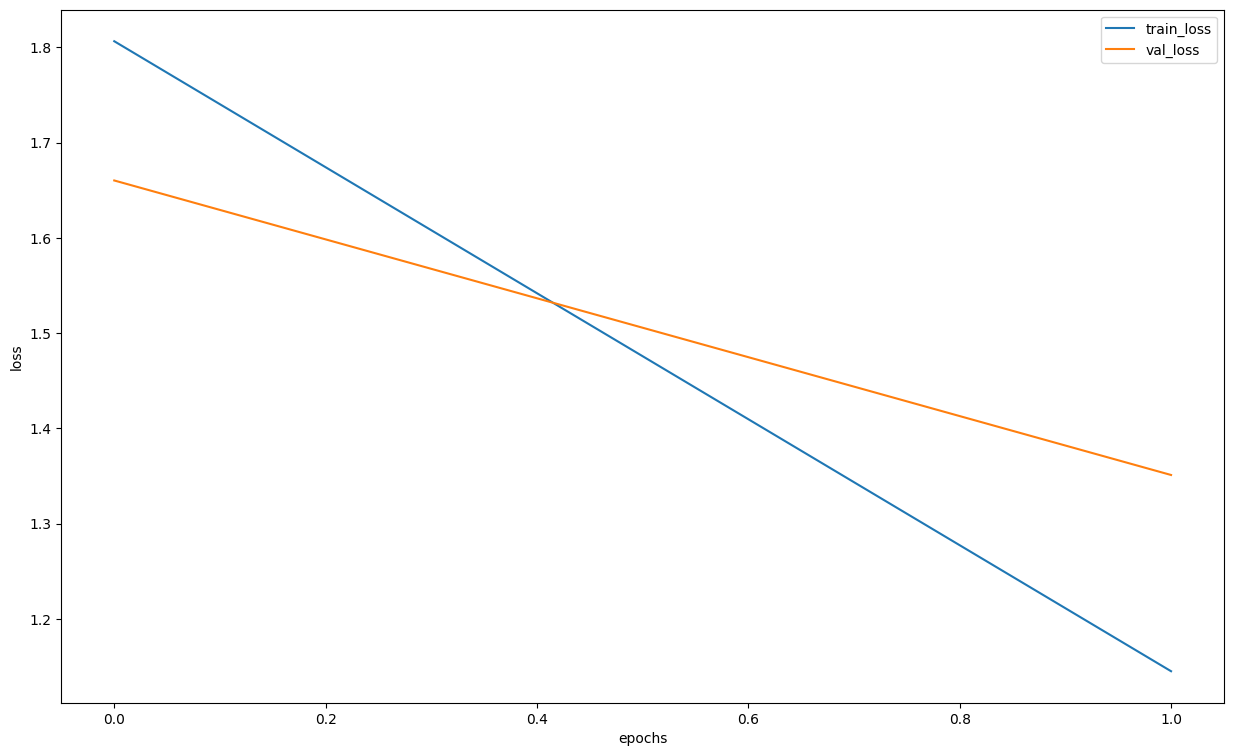

In [122]:
loss, acc, val_loss, val_acc = zip(*history)
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

### Predict a sample

In [123]:
def predict_one_sample(model, inputs):
    with torch.no_grad():
        inputs = inputs.to(CFG.device())
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

### prodice and calculate f1-score

In [124]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(simple_cnn, ex_img.unsqueeze(0))
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(simple_cnn, imgs)
label_encoder = pickle.load(open("le.pkl", 'rb'))
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]
from sklearn.metrics import f1_score
f1 = f1_score(actual_labels, y_pred, average='micro')

print("F1-score:", f1)


F1-score: 0.45


it sucks after 2 epochs since augmentations take longer to learn

### visualize confidence of the CCN. it sucks

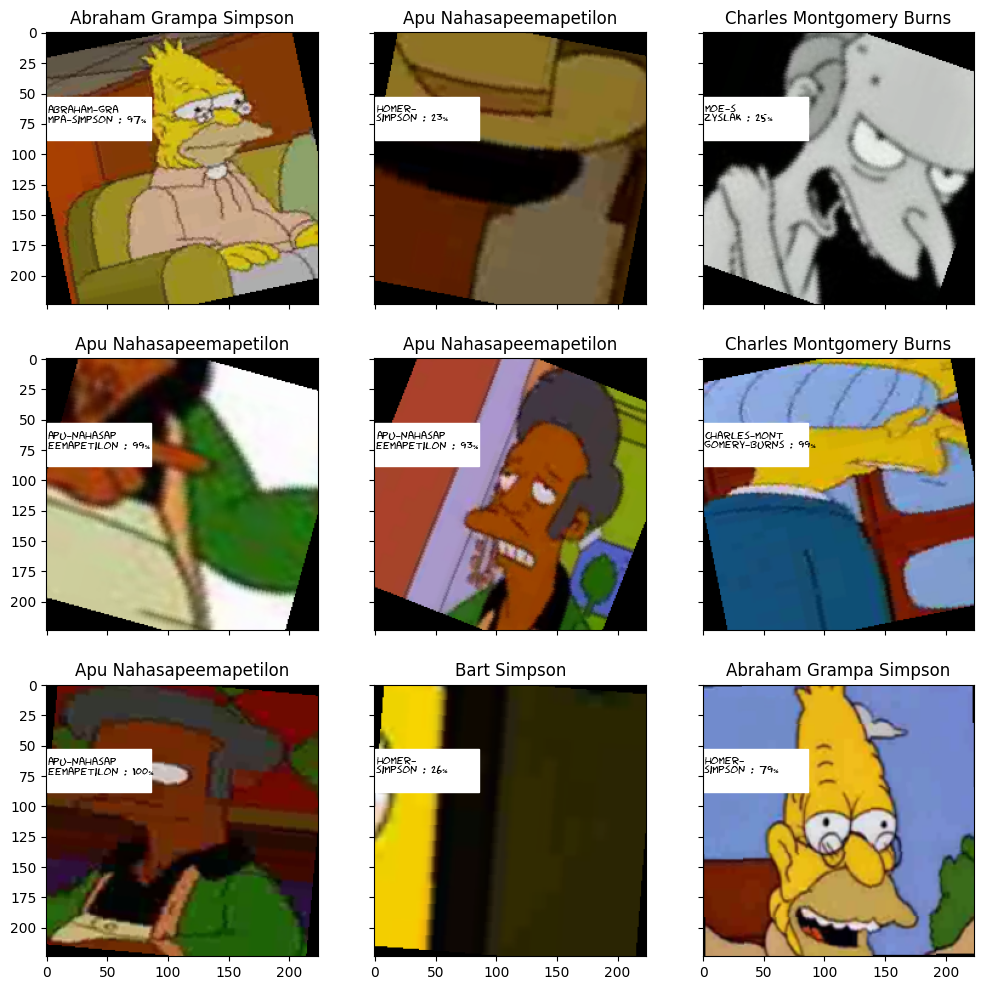

In [125]:

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.le.inverse_transform([label])[0].split('_')))

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

    actual_text = "Actual : {}".format(img_label)

    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(simple_cnn, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)

    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)

    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')